# Tonnetz Diffusion

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

sns.set_context('talk')

import numpy as np
import statsmodels.api as sm
from scipy.stats import entropy

In [2]:
intervals = ['+P5', '-P5', '+m3', '-m3', '+M3', '-M3']

In [3]:
def plot_parameters(df, cols, labels=None):
    
    fig, axes = plt.subplots(3,2,figsize=(16,10))
    axes = axes.flatten()

    for c, l, ax in zip(cols, labels, axes):
        sc = sns.regplot(
            x='year', 
            y=c, 
            data=df, 
            scatter_kws={'alpha':.3}, 
            line_kws={'color':'k'},
            marker='+',
            lowess=True,
            ax=ax
        )
        ax.set_ylabel(l)
        ax.set_xlabel('')
        ax.set_ylim(0,1)
    plt.tight_layout()
    return fig

In [4]:
def bootstrap_lowess(df, cols, labels=None, B=100, scatter=True, colors=None, alpha=.5):
    fig, axes = plt.subplots(3,2,figsize=(16,10))
    axes = axes.flatten()

    for i, (c, l, ax) in enumerate(zip(cols, labels, axes)):
        if scatter:
            sns.regplot(
            x='year', 
            y=c, 
            data=df,
            scatter_kws={'alpha':.2}, 
            marker='+',
            fit_reg=False,
            ax=ax
        )
        
        for b in range(B):
            b_sample = df[[c, 'year']].sample(df.shape[0], replace=True)

            x = b_sample.year.values
            y = b_sample[c].values
            lowess = sm.nonparametric.lowess(y, x, frac=0.3)

            ax.plot(lowess[:, 0], lowess[:, 1], alpha=alpha, c=colors[i%6]['color'])
        ax.set_ylabel(l)

    plt.tight_layout()
    return fig

read csv with a single decay parameter for all primary intervals

In [9]:
df = pd.read_csv('results.tsv', sep='\t').sort_values(by='year')
df.tail()

KLs       +P5       -P5       +m3  -m3       +M3       -M3  \
559  0.247376  0.648502  0.335230  0.005219  0.0  0.000000  0.011049   
558  0.222087  0.749888  0.218584  0.000000  0.0  0.000000  0.031528   
557  0.287002  0.581502  0.418498  0.000000  0.0  0.000000  0.000000   
556  0.303291  0.279340  0.710576  0.000000  0.0  0.010083  0.000000   
560  0.241167  0.615077  0.384618  0.000000  0.0  0.000000  0.000305   

     diffusion                                              piece composer  \
559   0.837857  ..\ExtendedTonality\data\DataFrames\Fear_no_mo...    Finzi   
558   0.766881  ..\ExtendedTonality\data\DataFrames\O_Mistress...    Finzi   
557   0.833101  ..\ExtendedTonality\data\DataFrames\Who_Is_Sil...    Finzi   
556   0.830923  ..\ExtendedTonality\data\DataFrames\Come_away_...    Finzi   
560   0.847814  ..\ExtendedTonality\data\DataFrames\It_was_a_l...    Finzi   

       year  
559  1942.0  
558  1942.0  
557  1942.0  
556  1942.0  
560  1942.0

In [7]:
df['tonal_center'] = df['piece'].apply(lambda x: pd.read_csv(x, engine='python').tpc.value_counts().idxmax())

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


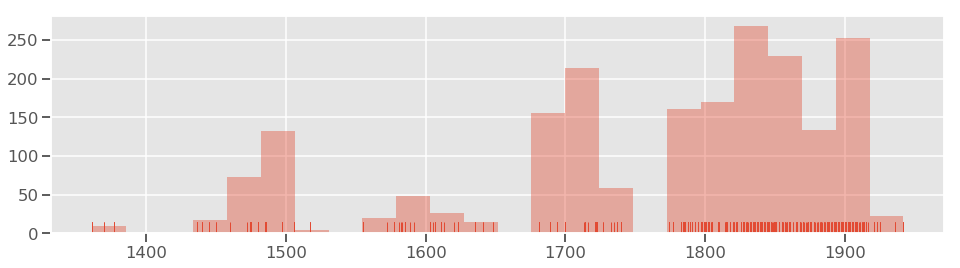

In [8]:
fig, ax = plt.subplots(figsize=(16,4))
sns.distplot(df.year.dropna(), rug=True, kde=False,norm_hist=False)
plt.xlabel('')
plt.savefig("img/corpus.png", dpi=300);

## Interval weights

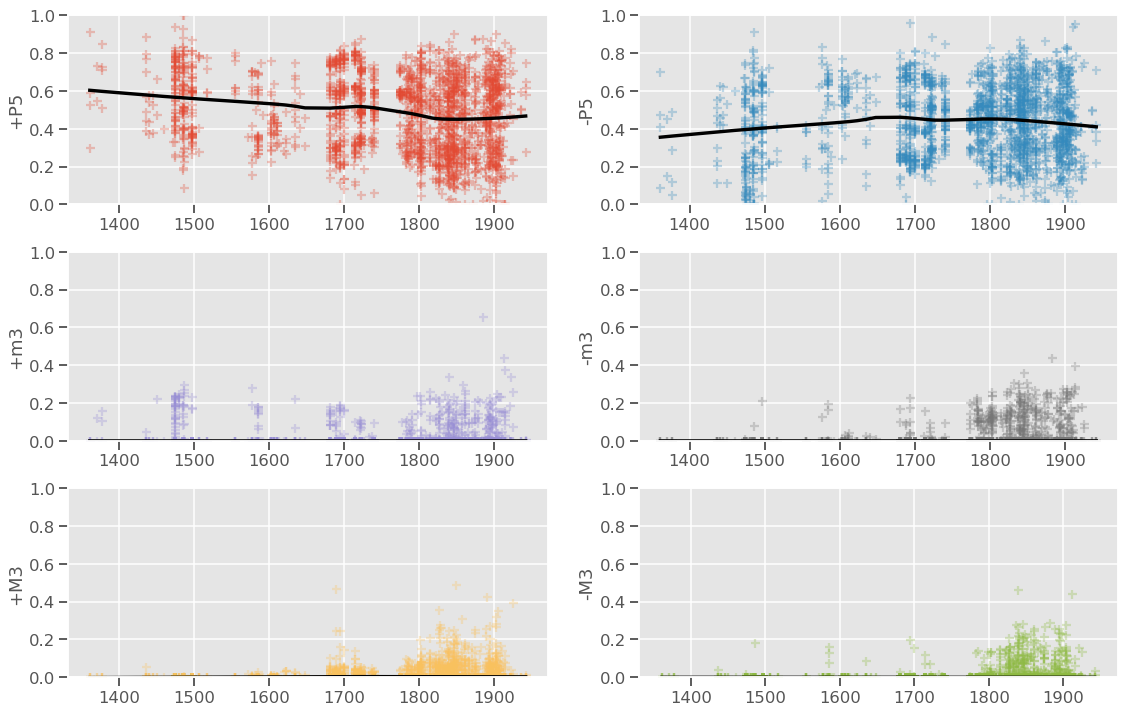

In [10]:
fig = plot_parameters(df, intervals, labels=intervals)
plt.savefig('img/interval_weights.png', dpi=300)

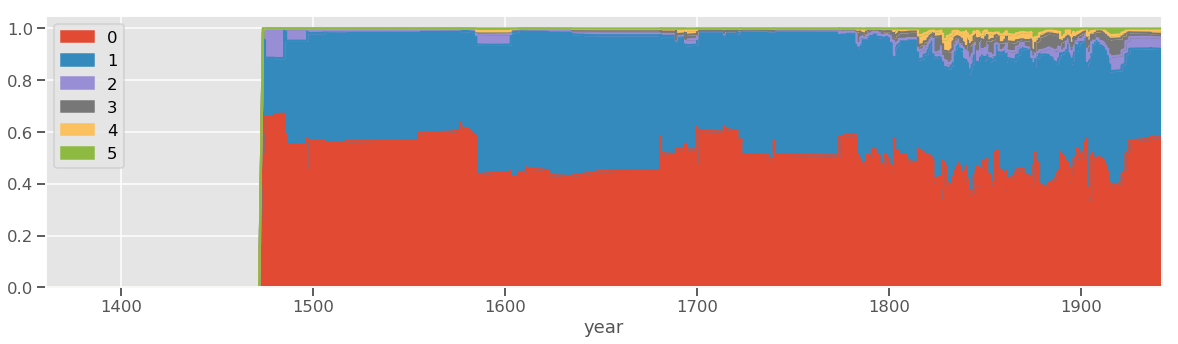

In [165]:
stacked = df.loc[:,[str(i) for i in range(6)]].rolling(window=30, win_type='cosine', center=False).mean()
stacked.index = df.year
stacked.plot(kind='area', figsize=(20,5))

plt.margins(0,0);

In [23]:
catcolors = list(plt.rcParams['axes.prop_cycle'])

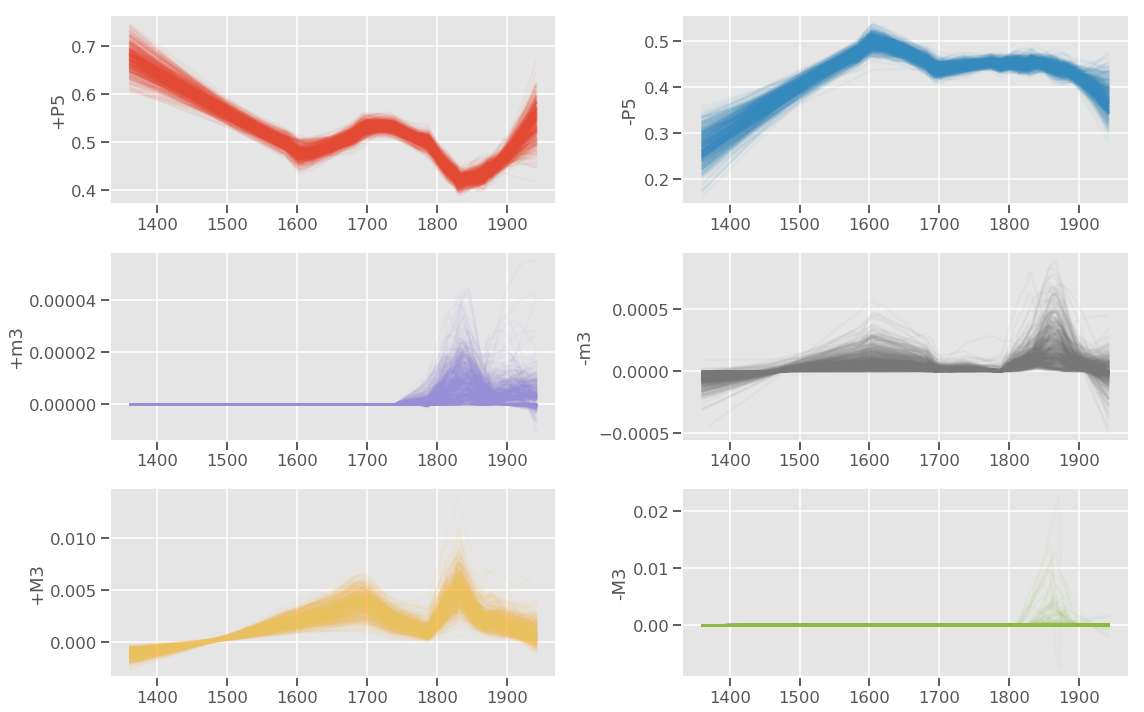

In [28]:
B = 500
fig = bootstrap_lowess(df, intervals, scatter=False, B=B, labels=intervals, colors=catcolors, alpha=.05)
plt.savefig('img/bootstrapped_weights.png', dpi=300)

Observations:
* It seems that there are strong correlations between +m3 and -M3 (major triad), and between -m3 and +M3 (minor triad). Viewed absolutely, the major triad components are stronger (because minor is a mixed mode?)
* If also taking the fifths into account: how do dualistic theories play out?
* +P5 and -P5 are almost inverse patterns "W" and "M" (slightly shifted in time towards the end)

## Diffusion parameter

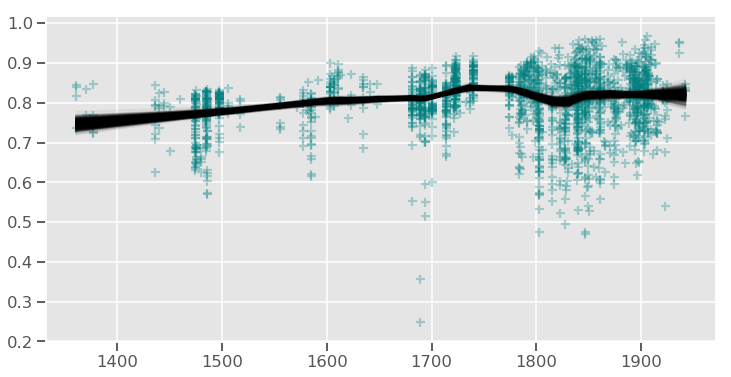

In [33]:
B = 500

fig, ax = plt.subplots(figsize=(12,6))

ax.scatter(df['year'], df['diffusion'], alpha=.3, marker='+', color='teal')

for b in range(B):
    b_sample = df[['diffusion', 'year']].sample(df.shape[0], replace=True)

    x = b_sample.year.values
    y = b_sample['diffusion'].values
    lowess = sm.nonparametric.lowess(y, x, frac=0.3)

    ax.plot(lowess[:, 0], lowess[:, 1], alpha=.05, c='k')
    
plt.savefig("img/bootstrapped_diffusion.png", dpi=300)

## Divergences from true distributions per composer

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


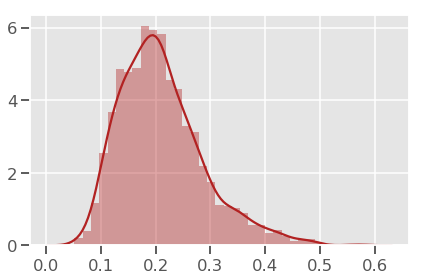

In [11]:
ax = sns.distplot(df.KLs, color='firebrick')
ax.set_xlabel('')
plt.tight_layout()
plt.savefig('img/KLs.png', dpi=300);

It doesn't seem to make a difference whether there is one global decay parameter (per piece) or one for each interval.

The global parameter values are largely determined by the fifths (+/-P5). Since the third components (+/-m3, +/-M3) are relatively weak they don't fall into the weight.

What would be an objective measure to show that it is better to include decay parameters for all intervals separately? The $d_JS$ values are not sufficiently different. It _should_ be the case that if the global decay parameter is high (around .8) that the third components are much weaker because everything is already covered by the fifths.

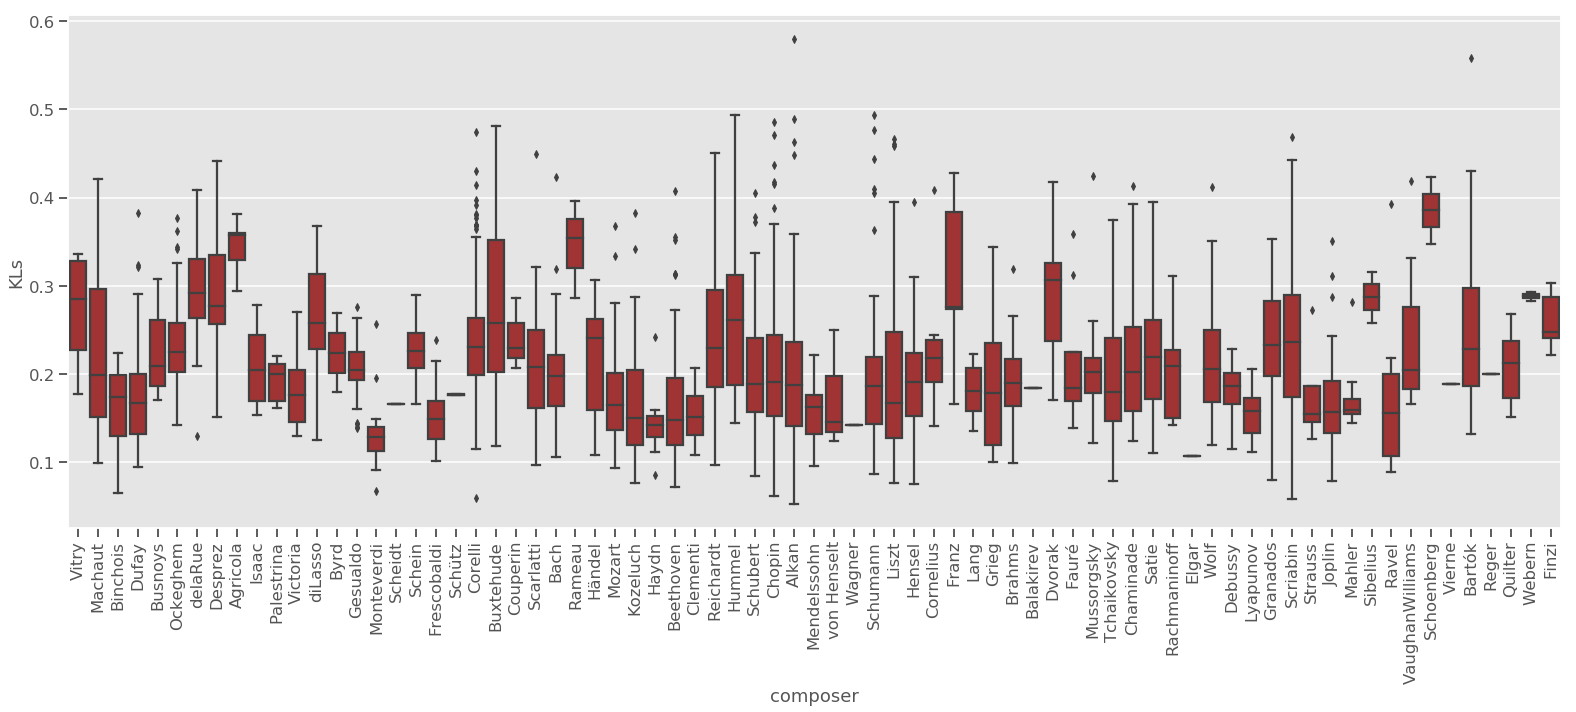

In [12]:
fig, ax = plt.subplots(figsize=(22,10))

sns.boxplot(
    x="composer", 
    y="KLs",
    color='firebrick',
    data=df, ax=ax)

ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.tight_layout()
# plt.ylim(0,1)
plt.savefig('img/KLs_composers.png', dpi=300)
plt.show()

In [172]:
best = df.loc[df.sqrtJSDs.idxmin()]
best

JSDs                                                    0.0140447
0                                                        0.294406
1                                                        0.538406
2                                                       0.0619583
3                                                         0.10523
4                                                     9.48677e-18
5                                                     3.52366e-18
6                                                        0.806698
file            ..\ExtendedTonality\data\DataFrames\Scherzo_Fo...
composer                                                    Alkan
year                                                         1847
tonal_center                                                   F#
sqrtJSDs                                                  0.11851
Name: 48, dtype: object

In [173]:
worst = df.loc[df.sqrtJSDs.idxmax()]
worst

JSDs                                                     0.169226
0                                                        0.407759
1                                                         0.10144
2                                                        0.329777
3                                                     5.88857e-18
4                                                         0.01771
5                                                        0.143314
6                                                        0.596016
file            ..\ExtendedTonality\data\DataFrames\Un_Morceau...
composer                                                    Alkan
year                                                         1840
tonal_center                                                   F#
sqrtJSDs                                                  0.41137
Name: 133, dtype: object

### Symmetry (dualistic perspective)
#### Parameter weights

In [205]:
ints = df[[str(i) for i in range(6)]].copy()
ints = ints.melt()
ints.variable = ints.variable.astype(int)
ints['direction'] = np.where(ints['variable'].apply(pd.to_numeric) % 2 == 0, 'acending', 'descending')
ints['interval'] = ['P5' if s in (0,1) else 'm3' if s in (2,3) else 'M3' if s in (4,5) else '' for s in ints.variable.values]
ints.head()

variable     value direction interval
0         0  0.530712  acending       P5
1         0  0.308556  acending       P5
2         0  0.911954  acending       P5
3         0  0.597453  acending       P5
4         0  0.554782  acending       P5

How does the symmetry change over time? Could the 19th century theorists have been "mislead" by contemporary music?

#### Plot

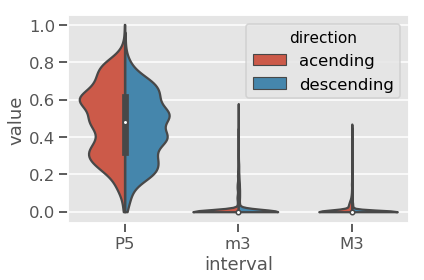

In [219]:
sns.violinplot(
    data=ints, 
    x='interval', 
    y='value', 
    hue='direction', 
    split=True,
    cut=0,
)
axes[0].set_ylabel('interval weights')
axes[0].set_xlabel('')

plt.tight_layout()
plt.savefig('img/parameter_dists.png', dpi=300);

### Parameter Clustering

In [183]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [184]:
for i in [0,2,4]:
    df[str(i)+"-"+str(i+1)] = df[str(i)] + df[str(i+1)]

In [185]:
ints_df = df.iloc[:,-3:]

In [186]:
d = dict(
    zip(
        df.tonal_center.unique(),
        [i for i in range(df.tonal_center.unique().shape[0])]
    )
)
d

{'G': 0,
 'A': 1,
 'F': 2,
 'D': 3,
 'C': 4,
 'B': 5,
 'E': 6,
 'Bb': 7,
 'F#': 8,
 'C#': 9,
 'G#': 10,
 'Eb': 11,
 'Ab': 12,
 'A#': 13,
 'D#': 14,
 'Db': 15,
 'Gb': 16}

In [191]:
X_ = df.loc[:,[str(i) for i in range(0,7)]]

# multiply gammas by weights
# for i in range(6):
#     X_[str(i+6)] = X_[str(i)] * X_[str(i+6)]

n = 7
pca = PCA(n_components=n)
Y_ = pca.fit_transform(X_)

In [192]:
[pca.explained_variance_ratio_[i] for i in range(n)]

[0.7779207400191596,
 0.12402462949560578,
 0.03539126574640518,
 0.03034252288642905,
 0.021880801138592938,
 0.010440040713807436,
 1.1939618244108355e-16]

In [193]:
df['PC1'] = Y_[:,0]
df['PC2'] = Y_[:,1]
df['PC3'] = Y_[:,2]

In [194]:
pca_composers = df.groupby('composer')[['PC1', 'PC2']].median()

In [195]:
df.head()

JSDs         0         1             2             3             4  \
1444  0.088199  0.530712  0.469288  0.000000e+00  0.000000e+00  0.000000e+00   
1442  0.090362  0.308556  0.691444  3.872857e-14  0.000000e+00  1.173107e-16   
1443  0.068001  0.911954  0.088046  1.145758e-15  9.515092e-13  5.051767e-14   
1445  0.047936  0.597453  0.402547  0.000000e+00  0.000000e+00  0.000000e+00   
1400  0.049210  0.554782  0.445218  2.405438e-16  1.274886e-16  0.000000e+00   

                 5         6  \
1444  0.000000e+00  0.821497   
1442  2.676678e-15  0.796660   
1443  7.181484e-15  0.712268   
1445  0.000000e+00  0.823258   
1400  0.000000e+00  0.815621   

                                                   file composer    year  \
1444  ..\ExtendedTonality\data\DataFrames\Lugentium-...    Vitry  1361.0   
1442  ..\ExtendedTonality\data\DataFrames\Virtutibus...    Vitry  1361.0   
1443  ..\ExtendedTonality\data\DataFrames\Gratissima...    Vitry  1361.0   
1445  ..\ExtendedTonality\data\DataFrames\Rex-quem-m...    Vitry  1361.0   
1400  ..\ExtendedTonality\data\DataFrames\Messe-de-N...  Machaut  1370.0   

     tonal_center  sqrtJSDs  0-1           2-3           4-5       PC1  \
1444            G  0.296983  1.0  0.000000e+00  0.000000e+00 -0.010200   
1442            A  0.300603  1.0  3.872857e-14  2.793989e-15  0.301546   
1443            F  0.260770  1.0  9.526550e-13  5.769915e-14 -0.549667   
1445            G  0.218943  1.0  0.000000e+00  0.000000e+00 -0.104025   
1400            D  0.221833  1.0  3.680324e-16  0.000000e+00 -0.044230   

           PC2       PC3  
1444 -0.060274 -0.012713  
1442 -0.047699 -0.045235  
1443  0.021849 -0.061494  
1445 -0.060159 -0.006868  
1400 -0.055786 -0.015090

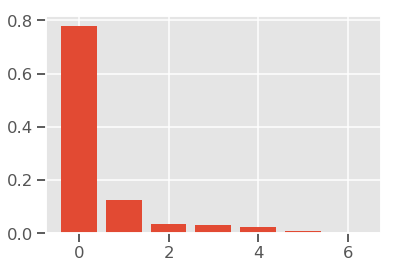

In [196]:
plt.bar(np.arange(n),pca.explained_variance_ratio_);

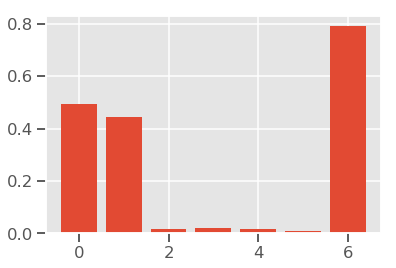

In [197]:
plt.bar(np.arange(n),pca.mean_);

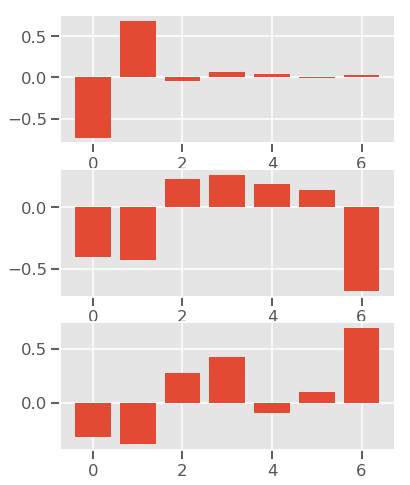

In [198]:
fig, axes = plt.subplots(3,1, figsize=(6,8))
for v, ax in zip(pca.components_[:3], axes):
#     ax.bar(np.arange(12),v, alpha=.5)
    ax.bar(np.arange(n),v)

---> use the principle components and plot the diffusion model for these settings

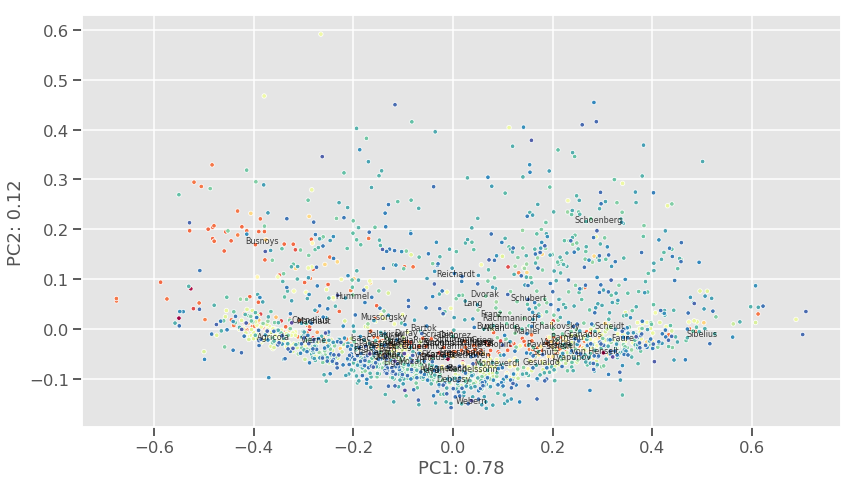

In [201]:
fig, ax = plt.subplots(figsize=(12,12))

ax.set_aspect('equal')
sns.scatterplot(Y_[:,0], Y_[:,1], alpha=1, marker='.', hue=df['year'], palette='Spectral', ax=ax)

for c, (x,y) in pca_composers.iterrows():
    ax.text(x,y,c, alpha=.75, va='center', ha='center', fontsize=8)
    
ax.set_xlabel("PC1: " + str(round(pca.explained_variance_ratio_[0],2)))
ax.set_ylabel("PC2: " + str(round(pca.explained_variance_ratio_[1],2)))
    
ax.get_legend().remove()
plt.tight_layout()
plt.savefig("img/TDM_PCA.png", dpi=600);

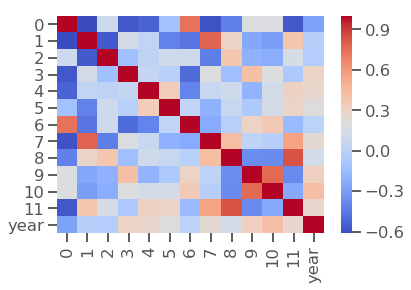

In [197]:
sns.heatmap(df[[str(i) for i in range(12)]+['year']].corr(), cmap='coolwarm')

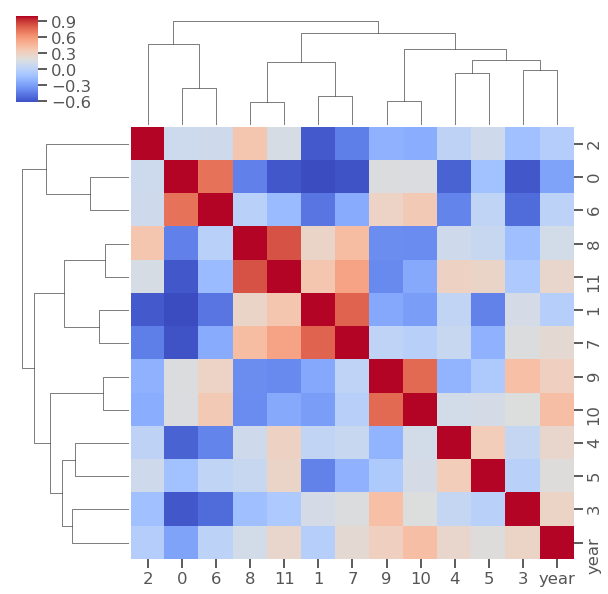

In [198]:
sns.clustermap(df[[str(i) for i in range(12)]+['year']].corr(), cmap='coolwarm')

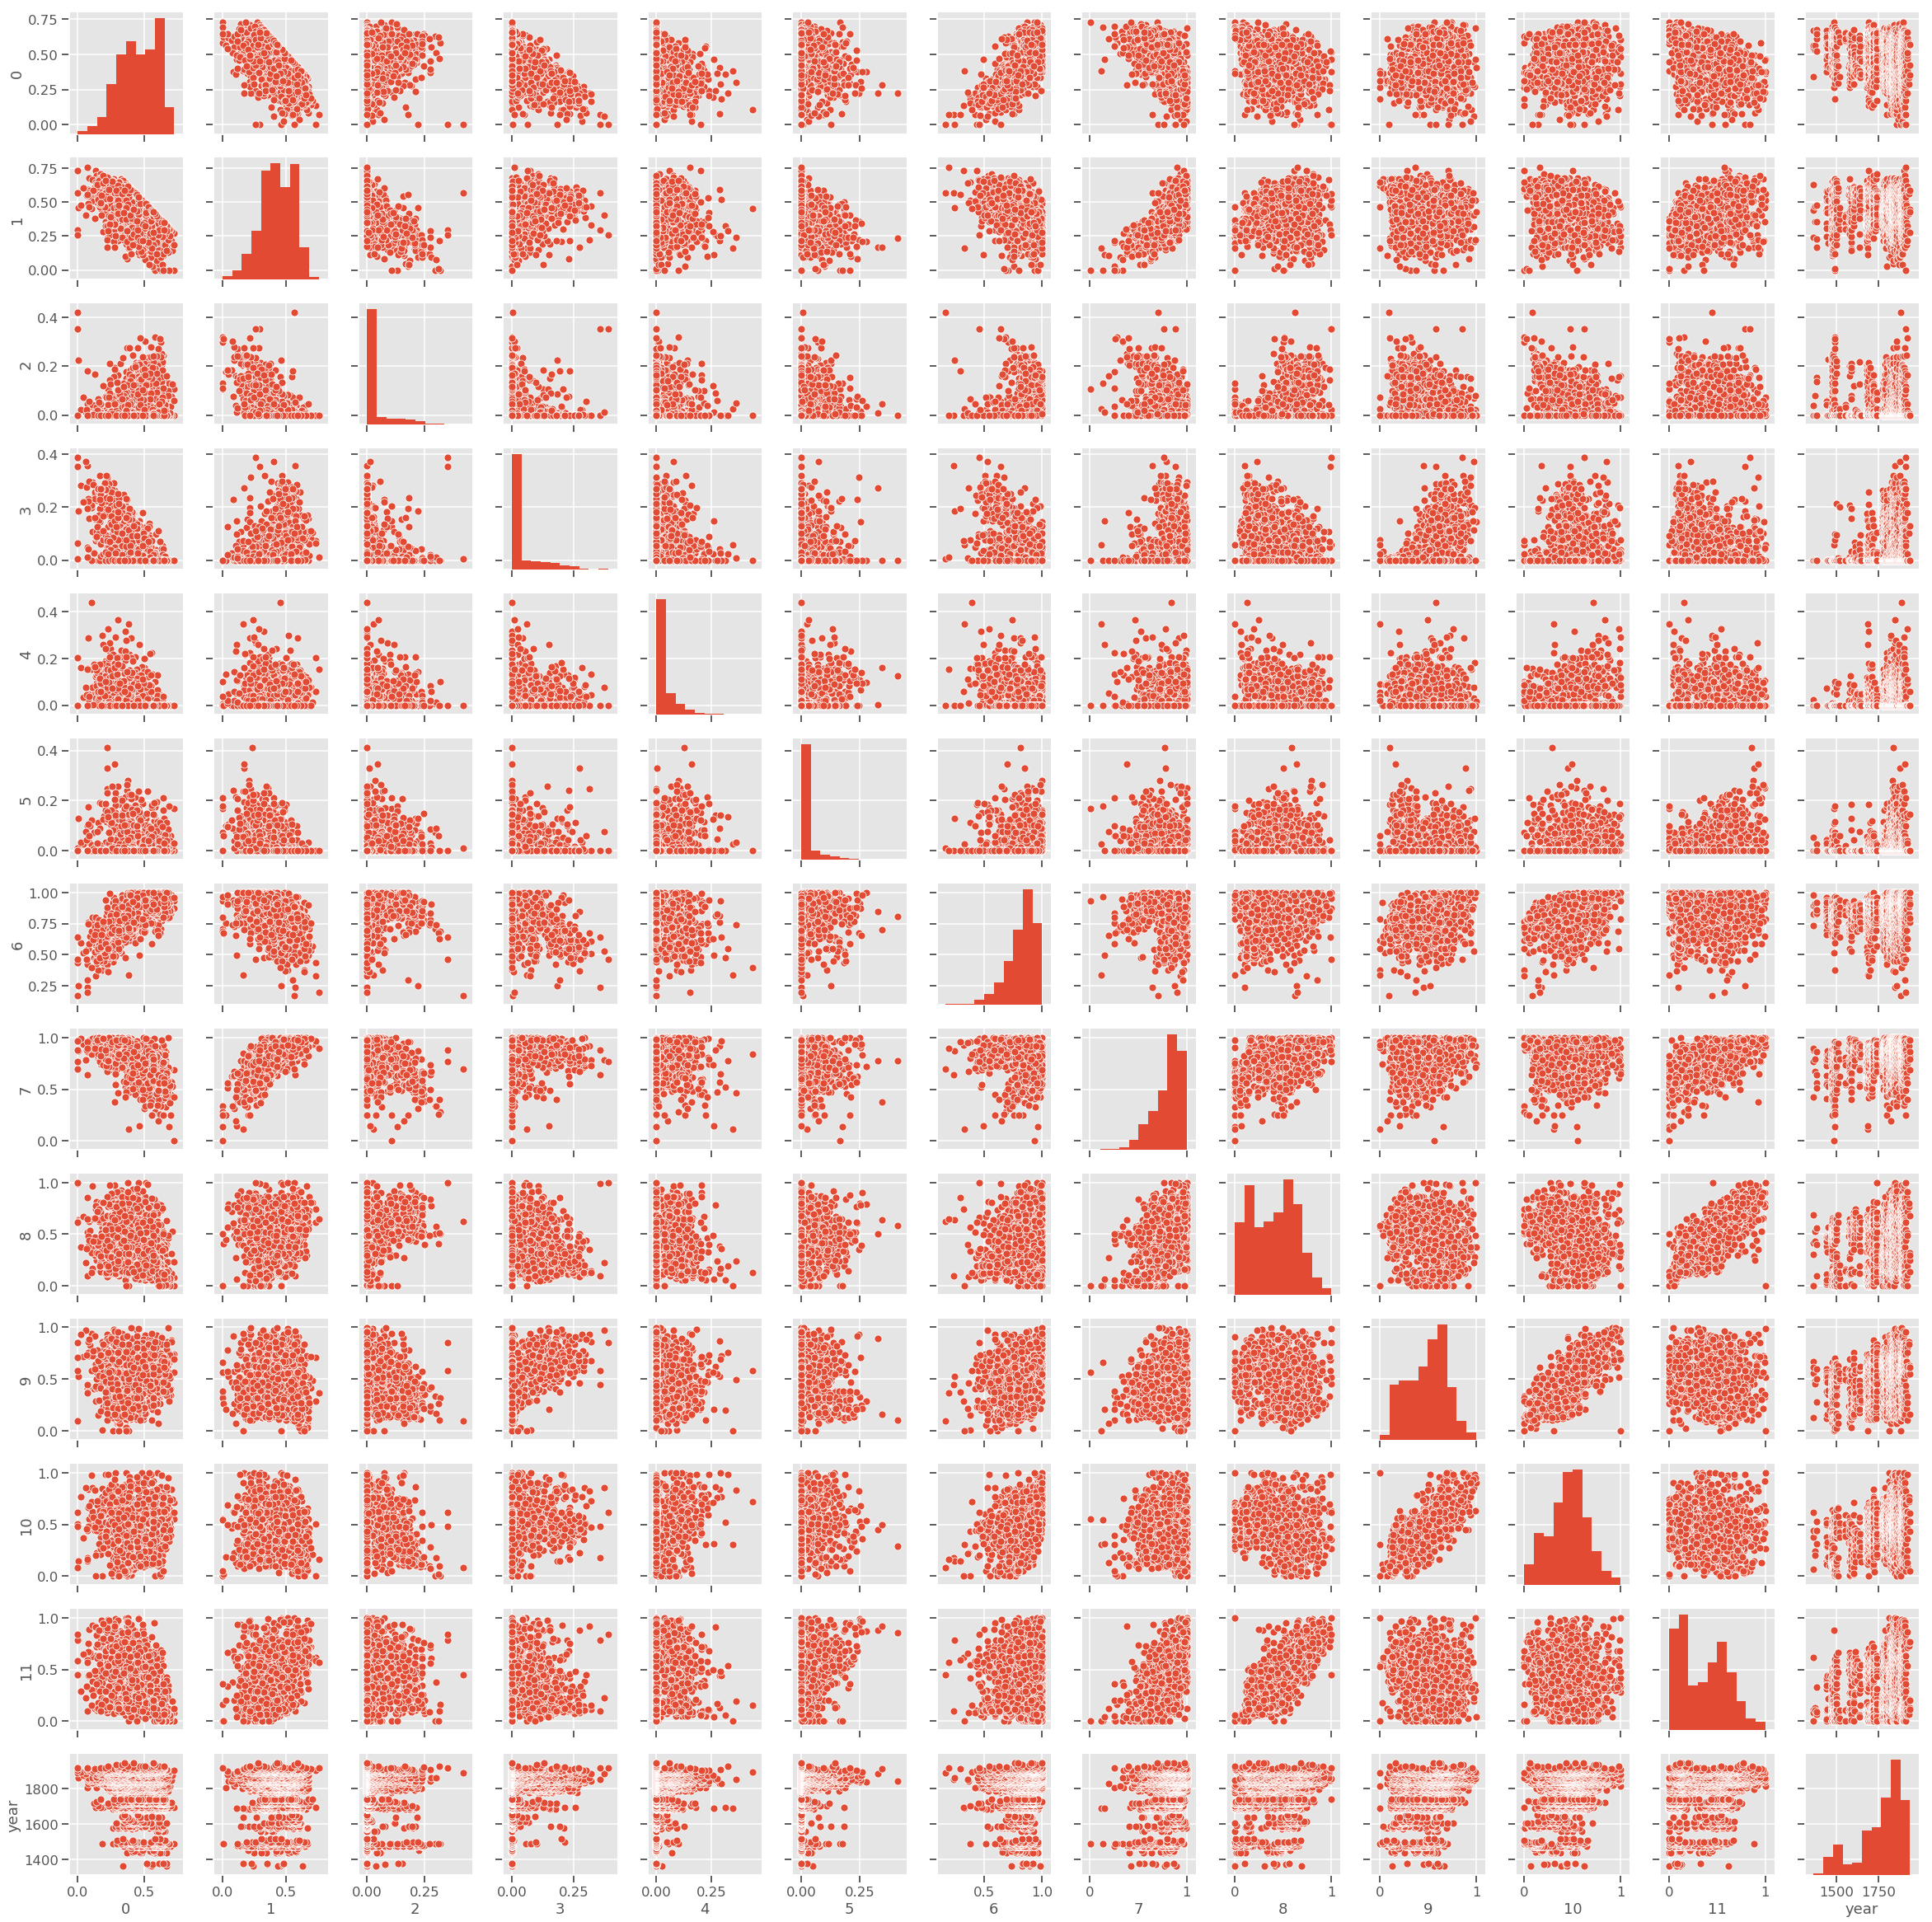

In [184]:
sns.pairplot(df[[str(i) for i in range(12)]+['year']])